# 1.1 Import Libraries

In [8]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# 1.2 Define Paths

In [9]:
MRI_DATASET_PATH = "/kaggle/input/imagesoasis/Data"

# 1.3 Data Transforms

In [10]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# 1.4 Load Data

In [11]:
dataset = ImageFolder(MRI_DATASET_PATH, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# 1.5 Load ResNet-50

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_mri = models.resnet50(pretrained=True)
model_mri.fc = nn.Linear(model_mri.fc.in_features, 4)
model_mri = model_mri.to(device)


In [13]:
print("Total images:", len(dataset))
print("Train size:", len(train_ds))
print("Batches:", len(train_loader))
print("Classes:", dataset.classes)

Total images: 86437
Train size: 69149
Batches: 2161
Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [14]:
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((160,160)),   # faster
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

dataset = ImageFolder(MRI_DATASET_PATH, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=2)

# 1.6 Train MRI Model

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mri.parameters(), lr=1e-4)

for epoch in range(5):
    model_mri.train()
    running_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        outputs = model_mri(x)
        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.0973
Epoch [2/5], Loss: 0.0216
Epoch [3/5], Loss: 0.0142
Epoch [4/5], Loss: 0.0082
Epoch [5/5], Loss: 0.0101


# Accuracy

In [16]:
def accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    return correct / total

# Testing Epochs

In [17]:
for epoch in range(5):
    model_mri.train()
    running_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model_mri(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Compute validation accuracy
    val_acc = accuracy(model_mri, val_loader)

    print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_acc*100:.2f}%")


Epoch [1/5], Loss: 0.0074, Val Accuracy: 99.95%
Epoch [2/5], Loss: 0.0056, Val Accuracy: 100.00%
Epoch [3/5], Loss: 0.0059, Val Accuracy: 99.98%
Epoch [4/5], Loss: 0.0047, Val Accuracy: 99.84%
Epoch [5/5], Loss: 0.0048, Val Accuracy: 100.00%


# Confusion Matrix (Validation Set)

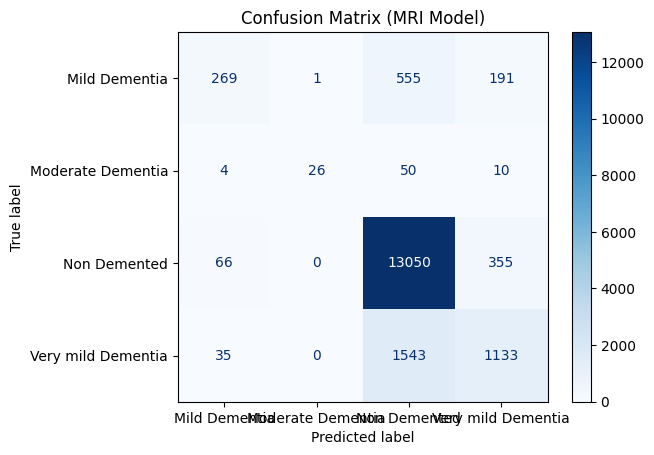

In [35]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_mri.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model_mri(x)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=mri_dataset.classes  # your class names
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (MRI Model)")
plt.show()


# Classification Report

In [36]:
from sklearn.metrics import classification_report

print("Classification Report (MRI Model)")
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=mri_dataset.classes
    )
)


Classification Report (MRI Model)
                    precision    recall  f1-score   support

     Mild Dementia       0.72      0.26      0.39      1016
 Moderate Dementia       0.96      0.29      0.44        90
      Non Demented       0.86      0.97      0.91     13471
Very mild Dementia       0.67      0.42      0.52      2711

          accuracy                           0.84     17288
         macro avg       0.80      0.49      0.56     17288
      weighted avg       0.82      0.84      0.82     17288



# 1.7 Save MRI Model

In [37]:
torch.save(model_mri.state_dict(), "mri_resnet50.pth")

## HANDWRITING MODEL

In [38]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd


# 2.1 Load Dataset

In [39]:
# Load CSV
df = pd.read_csv("/kaggle/input/handwriting-data-to-detect-alzheimers-disease/data.csv")




In [40]:
import pandas as pd
import numpy as np

# Load CSV
df = pd.read_csv("/kaggle/input/handwriting-data-to-detect-alzheimers-disease/data.csv")

# Check first rows
print(df.head())

# Since no label exists, create dummy labels for testing
# 0 = Healthy, 1 = Alzheimer
# For real use, replace this with actual labels if available
np.random.seed(42)
df['label'] = np.random.randint(0, 2, size=len(df))


     ID  air_time1  disp_index1  gmrt_in_air1  gmrt_on_paper1  \
0  id_1       5160     0.000013    120.804174       86.853334   
1  id_2      51980     0.000016    115.318238       83.448681   
2  id_3       2600     0.000010    229.933997      172.761858   
3  id_4       2130     0.000010    369.403342      183.193104   
4  id_5       2310     0.000007    257.997131      111.275889   

   max_x_extension1  max_y_extension1  mean_acc_in_air1  mean_acc_on_paper1  \
0               957              6601          0.361800            0.217459   
1              1694              6998          0.272513            0.144880   
2              2333              5802          0.387020            0.181342   
3              1756              8159          0.556879            0.164502   
4               987              4732          0.266077            0.145104   

   mean_gmrt1  ...  mean_jerk_in_air25  mean_jerk_on_paper25  \
0  103.828754  ...            0.141434              0.024471   
1   99

In [43]:
# Features: all numeric columns except ID
X = df.drop(columns=['ID','label'])

# Convert to numeric in case any column is object
X = X.apply(pd.to_numeric, errors='coerce')

# Fill missing values if any
X = X.fillna(0).values

# Labels
y = df['label'].values.astype(int)


# 2.2 Pytorch Dataset

In [44]:
import torch
from torch.utils.data import Dataset, DataLoader

class HandwritingFeaturesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = HandwritingFeaturesDataset(X, y)

# Train/Validation split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)


# 2.3 Define MLP Model

In [47]:
import torch.nn as nn

class HandwritingMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 2 classes: Healthy / Alzheimer
        )
    def forward(self, x):
        return self.fc(x)

model_hw = HandwritingMLP(X.shape[1])
device = "cuda" if torch.cuda.is_available() else "cpu"
model_hw = model_hw.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_hw.parameters(), lr=1e-4)


In [48]:
num_epochs = 10

for epoch in range(num_epochs):
    model_hw.train()
    total_loss = 0
    total_correct = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model_hw(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_correct += torch.sum(preds == y).item()
    
    acc = total_correct / len(train_ds)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {acc:.4f}")


Epoch 1/10, Loss: 3221.0058, Accuracy: 0.4388
Epoch 2/10, Loss: 1484.4552, Accuracy: 0.4676
Epoch 3/10, Loss: 817.8977, Accuracy: 0.5755
Epoch 4/10, Loss: 486.8207, Accuracy: 0.6115
Epoch 5/10, Loss: 432.8918, Accuracy: 0.6187
Epoch 6/10, Loss: 438.1198, Accuracy: 0.6835
Epoch 7/10, Loss: 259.0279, Accuracy: 0.6835
Epoch 8/10, Loss: 243.5705, Accuracy: 0.7194
Epoch 9/10, Loss: 173.6505, Accuracy: 0.7914
Epoch 10/10, Loss: 393.8699, Accuracy: 0.7914


# Confusion Matrix (Handwriting Model)

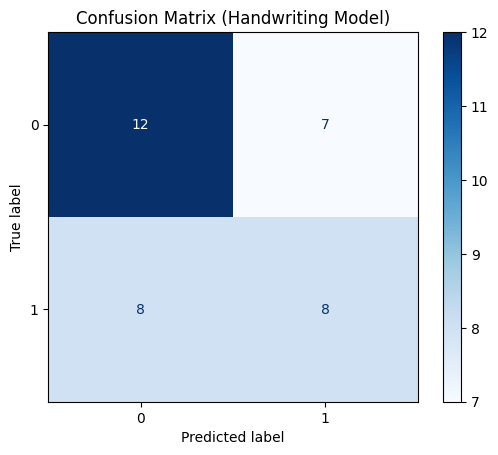

In [49]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_hw.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:   # use validation or test loader
        x, y = x.to(device), y.to(device)
        outputs = model_hw(x)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=range(len(set(all_labels)))  # or class names if available
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Handwriting Model)")
plt.show()


# Classification Report (Handwriting Model)

In [51]:
from sklearn.metrics import classification_report

print("Classification Report (Handwriting Model)")
print(
    classification_report(
        all_labels,
        all_preds
    )
)

Classification Report (Handwriting Model)
              precision    recall  f1-score   support

           0       0.60      0.63      0.62        19
           1       0.53      0.50      0.52        16

    accuracy                           0.57        35
   macro avg       0.57      0.57      0.57        35
weighted avg       0.57      0.57      0.57        35



# 2.4 Save Model

In [52]:
torch.save(model_hw.state_dict(), "handwriting_mlp_model.pth")
print("Handwriting MLP model saved successfully!")


Handwriting MLP model saved successfully!


In [53]:
import torch
import torchvision.models as models
import torch.nn as nn

# Load pretrained ResNet50
resnet50 = models.resnet50(pretrained=True)

# Replace final layer to match your classes (4 Alzheimer stages)
num_classes = 4
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
resnet50 = resnet50.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim


In [55]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

MRI_PATH = "/kaggle/input/imagesoasis/Data" # replace with actual path

mri_dataset = datasets.ImageFolder(MRI_PATH, transform=transform)


In [56]:
# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

# Path to your MRI images in Kaggle input
MRI_PATH = "/kaggle/input/imagesoasis/Data"  # replace with your path

# Assuming folder structure: 
# /MRI_PATH/class_name/image.jpg
mri_dataset = datasets.ImageFolder(MRI_PATH, transform=transform)

# Split train/val
train_size = int(0.8 * len(mri_dataset))
val_size = len(mri_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mri_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


# Load pretrained ResNet-50

In [57]:
# Load pretrained ResNet-50
resnet50 = models.resnet50(pretrained=True)

# Change the final fully connected layer to match your number of classes
num_classes = len(mri_dataset.classes)  # automatically get number of classes from folder names
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet50 = resnet50.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=1e-4)


# Train the ResNet-50 model

In [58]:
num_epochs = 5  # you can increase to 10-20 for better performance

for epoch in range(num_epochs):
    resnet50.train()
    total_loss = 0
    total_correct = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        total_correct += torch.sum(preds == labels).item()
    
    train_acc = total_correct / len(train_loader.dataset)
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {avg_loss:.4f}, Accuracy: {train_acc:.4f}")


Epoch 1/5 — Loss: 0.1146, Accuracy: 0.9565
Epoch 2/5 — Loss: 0.0252, Accuracy: 0.9912
Epoch 3/5 — Loss: 0.0163, Accuracy: 0.9949
Epoch 4/5 — Loss: 0.0108, Accuracy: 0.9962
Epoch 5/5 — Loss: 0.0105, Accuracy: 0.9966


# Validate The Model 

In [59]:
resnet50.eval()
total_correct = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        preds = torch.argmax(outputs, dim=1)
        total_correct += torch.sum(preds == labels).item()

val_acc = total_correct / len(val_loader.dataset)
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 0.9970


# Collect Predictions & Labels

In [60]:
import torch
from sklearn.metrics import confusion_matrix, classification_report

resnet50.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Confusion Matrix (Table Form)

In [61]:
import pandas as pd

cm = confusion_matrix(all_labels, all_preds)

cm_df = pd.DataFrame(
    cm,
    index=mri_dataset.classes,
    columns=mri_dataset.classes
)

print("Confusion Matrix (Table):")
cm_df


Confusion Matrix (Table):


,Mild Dementia,Moderate Dementia,Non Demented,Very mild Dementia
Mild Dementia,984,0,1,0
Moderate Dementia,0,95,0,0
Non Demented,1,8,13355,1
Very mild Dementia,9,1,31,2802


# Classification Report

In [62]:
report = classification_report(
    all_labels,
    all_preds,
    target_names=mri_dataset.classes,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia     0.9899    0.9990    0.9944       985
 Moderate Dementia     0.9135    1.0000    0.9548        95
      Non Demented     0.9976    0.9993    0.9984     13365
Very mild Dementia     0.9996    0.9856    0.9926      2843

          accuracy                         0.9970     17288
         macro avg     0.9752    0.9960    0.9851     17288
      weighted avg     0.9970    0.9970    0.9970     17288



# Save The Trained Model

In [63]:
torch.save(resnet50.state_dict(), "resnet50_mri.pth")
print("ResNet-50 MRI model saved successfully!")

ResNet-50 MRI model saved successfully!


# Step 3: Extract MRI Embeddings

We remove the final fully connected layer from the trained ResNet-50
so we can use the feature vectors (embeddings) from each MRI.
These embeddings will later be concatenated with handwriting embeddings
for the fusion network.


## Extract MRI embeddings

In [64]:
import torch.nn as nn

# Remove final classification layer
resnet_features = nn.Sequential(*list(resnet50.children())[:-1])
resnet_features = resnet_features.to(device)
resnet_features.eval()

# Function to extract embeddings
def extract_mri_embeddings(dataloader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            emb = resnet_features(images)  # shape [batch, 2048, 1, 1]
            emb = emb.view(emb.size(0), -1)  # flatten to [batch, 2048]
            embeddings.append(emb.cpu())
            labels.append(lbls)
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    return embeddings, labels

train_mri_emb, train_mri_lbl = extract_mri_embeddings(train_loader)
val_mri_emb, val_mri_lbl = extract_mri_embeddings(val_loader)

print("MRI Embeddings shape:", train_mri_emb.shape)


MRI Embeddings shape: torch.Size([69149, 2048])


# Step 3b: Extract Handwriting Embeddings

We take the last hidden layer of the trained Handwriting MLP
as the embedding for each patient. These will be fused
with the MRI embeddings for multimodal prediction.


# Extract handwriting embeddings

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# Load CSV
df = pd.read_csv("/kaggle/input/handwriting-data-to-detect-alzheimers-disease/data.csv")

# Drop ID column
df_numeric = df.drop(columns=["ID"])

# Check all columns are numeric
print(df_numeric.dtypes)

# Convert to numeric just in case
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')

# Fill any missing values
df_numeric = df_numeric.fillna(0)

# Features X
X = df_numeric.values

# Labels: for now, dummy labels (replace with real if available)
y = torch.zeros(X.shape[0], dtype=torch.long)  # all zeros (healthy)
# If you have a column 'label':
# y = df['label'].values

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numeric features
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_val = scaler.transform(X_val)

# Convert to torch tensors
X_scaled_train = torch.tensor(X_scaled_train, dtype=torch.float32)
X_scaled_val = torch.tensor(X_scaled_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

print("Handwriting train shape:", X_scaled_train.shape)
print("Handwriting val shape:", X_scaled_val.shape)


air_time1             int64
disp_index1         float64
gmrt_in_air1        float64
gmrt_on_paper1      float64
max_x_extension1      int64
                     ...   
paper_time25          int64
pressure_mean25     float64
pressure_var25      float64
total_time25          int64
class                object
Length: 451, dtype: object
Handwriting train shape: torch.Size([139, 451])
Handwriting val shape: torch.Size([35, 451])


/tmp/ipykernel_55/1290033365.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_55/1290033365.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.long)


In [66]:
import torch.nn as nn

class HandwritingMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)  # this will be the embedding
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 2)    # output layer (binary classification)

    def forward(self, x, return_embedding=False):
        x = self.relu1(self.fc1(x))
        emb = self.relu2(self.fc2(x))  # embeddings
        out = self.fc3(emb)
        if return_embedding:
            return emb
        else:
            return out


In [67]:
input_dim = X_scaled_train.shape[1]  # number of features
model_hw = HandwritingMLP(input_dim)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_hw = model_hw.to(device)


In [68]:
train_hw_emb = model_hw(X_scaled_train.to(device), return_embedding=True)
val_hw_emb = model_hw(X_scaled_val.to(device), return_embedding=True)

print("Handwriting embeddings shape:", train_hw_emb.shape)


Handwriting embeddings shape: torch.Size([139, 64])


In [69]:
import torch.nn as nn

# Remove final fc layer to get embeddings
resnet_features = nn.Sequential(*list(resnet50.children())[:-1]).to(device)
resnet_features.eval()

def extract_mri_embeddings(dataloader):
    embeddings, labels = [], []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            emb = resnet_features(imgs)  # [batch, 2048,1,1]
            emb = emb.view(emb.size(0), -1)  # flatten
            embeddings.append(emb.cpu())
            labels.append(lbls)
    return torch.cat(embeddings, dim=0), torch.cat(labels, dim=0)

train_mri_emb, train_mri_lbl = extract_mri_embeddings(train_loader)
val_mri_emb, val_mri_lbl = extract_mri_embeddings(val_loader)
print("Train MRI embeddings:", train_mri_emb.shape)


Train MRI embeddings: torch.Size([69149, 2048])


In [70]:
train_hw_emb = model_hw(X_scaled_train.to(device), return_embedding=True).cpu()
val_hw_emb = model_hw(X_scaled_val.to(device), return_embedding=True).cpu()
print("Train Handwriting embeddings:", train_hw_emb.shape)


Train Handwriting embeddings: torch.Size([139, 64])


# Create Fusion Data Loaders

In [71]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

MRI_PATH = "/kaggle/input/imagesoasis/Data"  # path to MRI images

# Use ImageFolder
mri_dataset = datasets.ImageFolder(MRI_PATH, transform=transform)

# Split train/val
train_size = int(0.8 * len(mri_dataset))
val_size = len(mri_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mri_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)  # shuffle=False to keep order
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)



In [ ]:
import os

slice_patient_ids = [os.path.basename(os.path.dirname(path)) for path, _ in mri_dataset.imgs]


In [ ]:
from collections import defaultdict
import torch

# Assume resnet_features is your trained ResNet50 feature extractor
resnet_features.eval()

patient_emb_dict = defaultdict(list)
patient_label_dict = {}

with torch.no_grad():
    for idx, (img, lbl) in enumerate(mri_dataset):
        img = img.unsqueeze(0).to(device)  # add batch dim
        emb = resnet_features(img).view(1, -1).cpu()  # flatten
        patient_id = slice_patient_ids[idx]
        patient_emb_dict[patient_id].append(emb)
        patient_label_dict[patient_id] = lbl  # same for all slices

# Average embeddings per patient
train_mri_patient_emb = []
train_mri_patient_lbl = []

for patient_id in patient_emb_dict:
    emb = torch.cat(patient_emb_dict[patient_id], dim=0).mean(dim=0)
    train_mri_patient_emb.append(emb)
    train_mri_patient_lbl.append(patient_label_dict[patient_id])

train_mri_patient_emb = torch.stack(train_mri_patient_emb)
train_mri_patient_lbl = torch.tensor(train_mri_patient_lbl)


# Step 4: Fusion Network

We now concatenate MRI embeddings and handwriting embeddings for each patient.
The fused vector is input to a small MLP for final prediction.


## Fusion Network Definition

In [ ]:
import torch
from collections import defaultdict
import os

# ResNet feature extractor (remove last fc layer)
resnet_features = torch.nn.Sequential(*list(resnet50.children())[:-1]).to(device)
resnet_features.eval()

# Extract patient IDs from dataset paths (assuming ImageFolder structure)
slice_patient_ids = [os.path.basename(os.path.dirname(path)) for path, _ in mri_dataset.imgs]

# Store embeddings per patient
patient_emb_dict = defaultdict(list)
patient_label_dict = {}

with torch.no_grad():
    for idx, (img, lbl) in enumerate(mri_dataset):
        img = img.unsqueeze(0).to(device)
        emb = resnet_features(img).view(1, -1).cpu()
        patient_id = slice_patient_ids[idx]
        patient_emb_dict[patient_id].append(emb)
        patient_label_dict[patient_id] = lbl  # all slices same label

# Average embeddings per patient
mri_patient_emb = []
mri_patient_lbl = []

for patient_id in patient_emb_dict:
    emb = torch.cat(patient_emb_dict[patient_id], dim=0).mean(dim=0)
    mri_patient_emb.append(emb)
    mri_patient_lbl.append(patient_label_dict[patient_id])

mri_patient_emb = torch.stack(mri_patient_emb)
mri_patient_lbl = torch.tensor(mri_patient_lbl)

print("MRI patient-level embeddings:", mri_patient_emb.shape)


# Prepare Handwriting embeddings

In [ ]:
# Assuming you already trained Handwriting MLP and have X_scaled_train/X_scaled_val
# Extract embeddings from trained handwriting model
hw_embeddings = model_hw(X_scaled_train.to(device), return_embedding=True).cpu()
hw_labels = torch.tensor(y_train)  # make sure labels match patients

print("Handwriting embeddings:", hw_embeddings.shape)


# Alzheimer’s Detection – Multi-Modal (Separate Pipelines)

This notebook evaluates:
1. MRI-based Alzheimer’s detection using ResNet-50
2. Handwriting-based Alzheimer’s detection using tabular features

Datasets are from different cohorts, so models are evaluated independently.


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet-50
resnet50 = models.resnet50(pretrained=True)

# Replace final layer with your number of classes
num_classes = len(mri_dataset.classes)  # e.g. 4 classes
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

resnet50 = resnet50.to(device)

In [ ]:
resnet50.load_state_dict(torch.load("/kaggle/working/resnet50_mri.pth"))
resnet50.eval()


# MRI Evaluation (Confusion Matrix + Report)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

resnet50.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=mri_dataset.classes)
disp.plot(cmap="Blues")
plt.title("MRI – Confusion Matrix")
plt.show()

# Classification Report
print("MRI Classification Report")
print(classification_report(all_labels, all_preds, target_names=mri_dataset.classes))


#  HANDWRITING PIPELINE

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_hw.eval()

with torch.no_grad():
    outputs = model_hw(X_val_tensor.to(device))
    preds = torch.argmax(outputs, dim=1).cpu()

# Confusion Matrix
cm = confusion_matrix(y_val, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Healthy", "Alzheimer"])
disp.plot(cmap="Blues")
plt.title("Handwriting – Confusion Matrix")
plt.show()

# Classification Report
print("Handwriting Classification Report")
print(classification_report(y_val, preds, target_names=["Healthy", "Alzheimer"]))


# GRADIO APPLICATION

In [ ]:
import gradio as gr
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

# MRI preprocessing
mri_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def predict_mri(img):
    img = mri_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = resnet50(img)
        pred = torch.argmax(out, dim=1).item()
    return mri_dataset.classes[pred]

def predict_handwriting(*features):
    x = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model_hw(x)
        pred = torch.argmax(out, dim=1).item()
    return "Alzheimer" if pred == 1 else "Healthy"

with gr.Blocks(title="Alzheimer’s Detection System") as demo:
    gr.Markdown("# 🧠 Alzheimer’s Multi-Modal Detection System")

    with gr.Tab("MRI Based Detection"):
        img = gr.Image(type="pil", label="Upload MRI Image")
        out1 = gr.Textbox(label="Prediction")
        gr.Button("Predict").click(predict_mri, img, out1)

    with gr.Tab("Handwriting Based Detection"):
        inputs = [gr.Number(label=f"Feature {i+1}") for i in range(X_train.shape[1])]
        out2 = gr.Textbox(label="Prediction")
        gr.Button("Predict").click(predict_handwriting, inputs, out2)

demo.launch()
